In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME='C:\Program Files\Java\jdk-14.0.1'

In [ ]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers # 케라스의 옵티마이저를 임포트
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Embedding, Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout
from keras.optimizers import SGD,Adam
from keras.layers import BatchNormalization
from keras.layers import Activation

In [ ]:
import json
path = '/content/drive/Shareddrives/인공지능 경진대회/감성분류/input'
with open(path+'/'+'train_data.json', 'r') as f:
    json_train = json.load(f)
with open(path+'/'+'dev_data.json', 'r') as f:
    json_dev = json.load(f)

In [ ]:
print(len(json_train), len(json_dev))

15832 1717


# 'profile-id', 'type', 'content' 추출하기

In [ ]:
json_train[:1][0]['talk']['id']['profile-id'] # index

'Pro_10888'

In [ ]:
json_train[0:1][0]['talk']['content'] # feature

{'HS01': '기분이 좋지 않아',
 'HS02': '요새 건강검진을 받았는데 건강 상태가 좋지 않아.',
 'HS03': '이곳 저곳 관리해야 할 곳이 많아.',
 'SS01': '기분이 좋지 않은 이유를 알 수 있을까요?',
 'SS02': '많이 속상하시겠어요. 어디가 안 좋은가요?',
 'SS03': '안좋은 곳이 많아 걱정이 많으시겠어요.'}

# 토큰화

In [ ]:
okt = Okt(); 
X_train = []; X_dev = []
order = ['HS01', 'HS02', 'HS03', 'SS01', 'SS02', 'SS03'] # json파일의 발화 순서. 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '을', '것', '에서', '에게','게','이야','만','로',
             '.',',','?','!']

for i in range(len(json_train)):
    temp_X = []
    for j in order:
        temp_X += okt.morphs(json_train[i:i+1][0]['talk']['content'][j], stem=True) # 각 문장을 토큰화해서 temp_X에 append.
    temp_X = np.array(temp_X).flatten().tolist() # 2차원 list를 1차원으로 축소.
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거.
    X_train.append(temp_X) # X_train에 append.

for i in range(len(json_dev)):
    temp_X = []
    for j in order:
        temp_X += okt.morphs(json_dev[i:i+1][0]['talk']['content'][j], stem=True) # 각 문장을 토큰화해서 temp_X에 append.
    temp_X = np.array(temp_X).flatten().tolist() # 2차원 list를 1차원으로 축소.
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거.
    X_dev.append(temp_X) # X_train에 append.

In [ ]:
print(X_train[:1], X_dev[:1])

[['기분', '좋다', '않다', '요새', '건강검진', '받다', '건강', '상태', '좋다', '않다', '곳', '저', '곳', '관리', '곳', '많다', '기분', '좋다', '않다', '이유', '알', '수', '있다', '많이', '속상하다', '어디가', '안', '좋다', '안좋다', '곳', '많다', '걱정', '많다']] [['노후', '준비', '정말', '어렵다', '돈', '제일', '문제', '야', '적금', '이나', '저축', '얼마', '안되다', '문제', '지', '제일', '걱정', '뭐세', '요', '지금', '노후', '준비', '계시다', '가요', '저축', '해도', '금액', '적', '액수', '적다', '같다', '생각']]


# 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'있다': 1, '좋다': 2, '같다': 3, '친구': 4, '어떻다': 5, '보다': 6, '되다': 7, '나': 8, '내': 9, '생각': 10, '너무': 11, '수': 12, '않다': 13, '없다': 14, '많이': 15, '요': 16, '그렇다': 17, '안': 18, '들다': 19, '사람': 20, '마음': 21, '자다': 22, '못': 23, '일': 24, '받다': 25, '말': 26, '싶다': 27, '더': 28, '기분': 29, '정말': 30, '걱정': 31, '힘들다': 32, '하고': 33, '일이': 34, '거': 35, '적': 36, '때문': 37, '회사': 38, '결혼': 39, '많다': 40, '모르다': 41, '속상하다': 42, '때': 43, '상황': 44, '바라다': 45, '지금': 46, '준비': 47, '고': 48, '남편': 49, '분': 50, '그': 51, '가다': 52, '돼다': 53, '나다': 54, '다': 55, '되어다': 56, '해': 57, '직장': 58, '아니다': 59, '다른': 60, '건강': 61, '한테': 62, '돈': 63, '스럽다': 64, '응': 65, '대화': 66, '문제': 67, '고민': 68, '요즘': 69, '무슨': 70, '계시다': 71, '방법': 72, '인': 73, '취업': 74, '이야기': 75, '느끼다': 76, '가요': 77, '해보다': 78, '아이': 79, '왜': 80, '앞': 81, '아내': 82, '화가': 83, '위해': 84, '주다': 85, '오늘': 86, '해주다': 87, '맞다': 88, '군': 89, '해결': 90, '시간': 91, '크다': 92, '가족': 93, '얘기': 94, '당황': 95, '만나다': 96, '먹다': 97, '서': 98, '이제': 99, '스트레스': 100, '오다': 101, '대

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11053
등장 빈도가 1번 이하인 희귀 단어의 수: 2914
단어 집합에서 희귀 단어의 비율: 26.363883108658282
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.4075421877491196


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8141


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_dev = tokenizer.texts_to_sequences(X_dev)

In [ ]:
# y_train, y_dev 불러오기
y_train = []; y_dev = []
for i in range(len(json_train)):
    y_train += [json_train[i:i+1][0]['profile']['emotion']['type']] # json 파일 내의 감정 label

for i in range(len(json_dev)):
    y_dev += [json_dev[i:i+1][0]['profile']['emotion']['type']] # json 파일 내의 감정 label

print(y_train[20:25], y_dev[20:25])

['E12', 'E12', 'E13', 'E37', 'E12'] ['E39', 'E17', 'E37', 'E32', 'E44']


# 소분류

In [ ]:
# 소분류
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

y_train = lb_make.fit_transform(y_train) # string에서 int로 변환
y_train = to_categorical(y_train) # int에서 one-hot encoding

y_dev = lb_make.fit_transform(y_dev) # string에서 int로 변환
y_dev = to_categorical(y_dev) # int에서 one-hot encoding

# 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

15832
15832


# 패딩

대화의 최대 길이 : 139
대화의 평균 길이 : 45.16283476503285


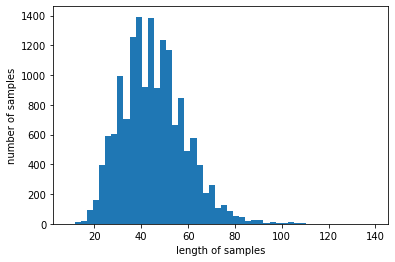

In [ ]:
print('대화의 최대 길이 :',max(len(l) for l in X_train))
print('대화의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 96.10282971197574


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_dev = pad_sequences(X_dev, maxlen = max_len)

# 모델링

## 기본 모델(with Tensorflow)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 512  #embedding 벡터의 차원은 512
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(embedding_dim))) 
model.add(Dense(embedding_dim, kernel_regularizer=tf.keras.regularizers.L2(0.01)))
# model.add(Dropout(0.1))
model.add(Dense(60, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

LR_INIT = 5e-4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    num = 30
    if epoch < num:
        lr = LR_INIT
    else:
        lr = LR_INIT * EXP_DECAY**(epoch-num)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT), loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc, lr_callback], batch_size=64, validation_split=0.1)

Epoch 1/50
223/223 [==============================] - ETA: 0s - loss: 5.1912 - acc: 0.0284
Epoch 00001: val_acc improved from -inf to 0.02083, saving model to best_model.h5
223/223 [==============================] - 18s 79ms/step - loss: 5.1912 - acc: 0.0284 - val_loss: 4.0183 - val_acc: 0.0208
Epoch 2/50
223/223 [==============================] - ETA: 0s - loss: 3.7257 - acc: 0.0579
Epoch 00002: val_acc improved from 0.02083 to 0.04356, saving model to best_model.h5
223/223 [==============================] - 17s 75ms/step - loss: 3.7257 - acc: 0.0579 - val_loss: 3.8365 - val_acc: 0.0436
Epoch 3/50
223/223 [==============================] - ETA: 0s - loss: 3.3846 - acc: 0.1140
Epoch 00003: val_acc improved from 0.04356 to 0.08333, saving model to best_model.h5
223/223 [==============================] - 17s 74ms/step - loss: 3.3846 - acc: 0.1140 - val_loss: 3.6847 - val_acc: 0.0833
Epoch 4/50
223/223 [==============================] - ETA: 0s - loss: 3.0844 - acc: 0.1688
Epoch 00004: va

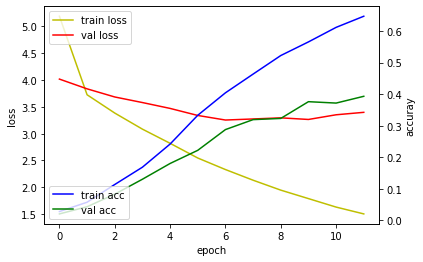

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_dev, y_dev)[1]))

54/54 [==============================] - 1s 13ms/step - loss: 3.7070 - acc: 0.3273

 테스트 정확도: 0.3273


# 대분류

In [ ]:
# y_train, y_dev 불러오기
y_train = []; y_dev = []
for i in range(len(json_train)):
    y_train += [json_train[i:i+1][0]['profile']['emotion']['type']] # json 파일 내의 감정 label

for i in range(len(json_dev)):
    y_dev += [json_dev[i:i+1][0]['profile']['emotion']['type']] # json 파일 내의 감정 label

In [ ]:
# 대분류

y_train_big = []
y_dev_big = []

regex1 = re.compile('E1.'); regex2 = re.compile('E2.'); regex3 = re.compile('E3.') # 정규 표현식 
regex4 = re.compile('E4.'); regex5 = re.compile('E5.'); regex6 = re.compile('E6.')

for i in range(len(y_train)):
    matchobj1 = regex1.match(y_train[i]);matchobj2 = regex2.match(y_train[i]);matchobj3 = regex3.match(y_train[i]);
    matchobj4 = regex4.match(y_train[i]);matchobj5 = regex5.match(y_train[i]);matchobj6 = regex6.match(y_train[i]);
    if matchobj1 != None:
        y_train_big.append(0)
    elif matchobj2 != None:
        y_train_big.append(1)
    elif matchobj3 != None:
        y_train_big.append(2)
    elif matchobj4 != None:
        y_train_big.append(3)   
    elif matchobj5 != None:
        y_train_big.append(4)
    elif matchobj6 != None:
        y_train_big.append(5)
    else:
        pass

for i in range(len(y_dev)):
    matchobj1 = regex1.match(y_dev[i]);matchobj2 = regex2.match(y_dev[i]);matchobj3 = regex3.match(y_dev[i]);
    matchobj4 = regex4.match(y_dev[i]);matchobj5 = regex5.match(y_dev[i]);matchobj6 = regex6.match(y_dev[i]);
    if matchobj1 != None:
        y_dev_big.append(0)
    elif matchobj2 != None:
        y_dev_big.append(1)
    elif matchobj3 != None:
        y_dev_big.append(2)
    elif matchobj4 != None:
        y_dev_big.append(3)   
    elif matchobj5 != None:
        y_dev_big.append(4)
    elif matchobj6 != None:
        y_dev_big.append(5)
    else:
        pass

y_train_big = to_categorical(y_train_big) # int에서 one-hot encoding
y_dev_big = to_categorical(y_dev_big) # int에서 one-hot encoding

In [ ]:
embedding_dim = 512  #embedding 벡터의 차원은 512
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(Bidirectional(LSTM(embedding_dim))) 
model2.add(Dense(embedding_dim))
# model2.add(Dropout(0.3))
model2.add(Dense(6, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

LR_INIT = 1e-3
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    num = 30
    if epoch < num:
        lr = LR_INIT
    else:
        lr = LR_INIT * EXP_DECAY**(epoch-num)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT), loss='categorical_crossentropy', metrics=['acc'])
hist2 = model2.fit(X_train, y_train_big, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.1)

Epoch 1/50
223/223 [==============================] - ETA: 0s - loss: 1.5479 - acc: 0.3919
Epoch 00001: val_acc improved from -inf to 0.45455, saving model to best_model_2.h5
223/223 [==============================] - 18s 79ms/step - loss: 1.5479 - acc: 0.3919 - val_loss: 1.5006 - val_acc: 0.4545
Epoch 2/50
223/223 [==============================] - ETA: 0s - loss: 1.0584 - acc: 0.6388
Epoch 00002: val_acc improved from 0.45455 to 0.53409, saving model to best_model_2.h5
223/223 [==============================] - 17s 76ms/step - loss: 1.0584 - acc: 0.6388 - val_loss: 1.3855 - val_acc: 0.5341
Epoch 3/50
223/223 [==============================] - ETA: 0s - loss: 0.8182 - acc: 0.7239
Epoch 00003: val_acc improved from 0.53409 to 0.54293, saving model to best_model_2.h5
223/223 [==============================] - 17s 76ms/step - loss: 0.8182 - acc: 0.7239 - val_loss: 1.4133 - val_acc: 0.5429
Epoch 4/50
223/223 [==============================] - ETA: 0s - loss: 0.6517 - acc: 0.7838
Epoch 000

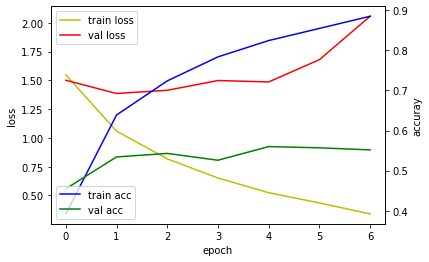

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist2.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
loaded_model2 = load_model('best_model_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_dev, y_dev_big)[1]))

54/54 [==============================] - 1s 12ms/step - loss: 1.6070 - acc: 0.5288

 테스트 정확도: 0.5288
